 Learn game play from raw pixels with Keras neural network
------- 

![](http://www.reactiongifs.com/r/mgc.gif)

Sources:   

- [Blog post](http://edersantana.github.io/articles/keras_rl/)  
- [Code](https://gist.github.com/EderSantana/c7222daa328f0e885093)  
- [Notebook](https://gist.github.com/cadurosar/bd54c723c1d6335a43c8)

WARNINGS:

- The code is kinda janky and the current frame rate might cause a seizure. 
- Note that Deep Q-Learning has its own patent by Google.

Catch Game
------

![](http://edersantana.github.io/articles/keras_rl/catch.gif)

Catch a single pixel “fruit” using a three pixel “basket”. 

he fruit falls one pixel per step and the Keras network gets a reward of +1 if it catches the fruit and -1 otherwise. 

In [1]:
reset -fs

In [2]:
import json
import time

from IPython import display
from keras.models import model_from_json, Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

from qlearn import Catch, ExperienceReplay

seaborn.set()
%matplotlib inline

Using TensorFlow backend.


__TODO__: For the game of _Catch_, what is the:

- environment
- agent
- actions
- reward

- environment: the pixels from the game state
- agent: the slider at the bottom of the image
- actions: left, right ,stay in the same place
- reward: catching the falling 'fruit'

__TODO__: Where in the code is the Reinforcement Learning? How does it work?

``` python
q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward == 1:
                win_cnt += 1

            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)            

            # adapt model
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            display_screen(action, 3000, inputs[0])            

            loss += model.train_on_batch(inputs, targets)
            ```

- First, we either choose a random action (following the greddy epsilon approach), or we predict the action to take based upon the current game state (model.predict(input_tm1)
- Next, we take the index of the action to pursue (np.argmax)
- Then, we apply the action (either the random action, or the predicted action) and observe the resulting image, the reward( -1,0, or 1), and whether the game is over or not.
- Afterwords, we store these state parameters in a list (memory)
- Next, we use get_batch to have pixels values associated with an exponentially descreasing reward

__TODO__: Reinforcement Learning has a notion of exploration. Where in the code is that?

``` python
if np.random.rand() <= epsilon: ## greedy E learning
                action = np.random.randint(0, num_actions, size=1)```

In [1]:
# This is the greedy epsilon approach to exploration where we take a random action 

__TODO__: Does a greedy algorithm work for the game of Catch?

- Yes it can work. Since there is only one fruit at a time, this algorithm can make locally optimal decisions and  still win the game.
- As long as there are not long-term dependencies in the game, a greedy approach should work

In [3]:
def display_screen(action, points, input_t):
    global last_frame_time
    display.clear_output(wait=True)
    print("Action {}, Points: {}".format(translate_action[int(action)], points))
    if ("End" not in translate_action[int(action)]) :
        plt.imshow(input_t.reshape((grid_size,)*2),
                   interpolation='none', 
                   cmap='gray')
        display.display(plt.gcf())
    last_frame_time = set_max_fps(last_frame_time)

def set_max_fps(last_frame_time, FPS = 1):
    current_milli_time = lambda: int(round(time.time() * 1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()

def test(model):
    "Test pretrained Keras model to play catch"
    global last_frame_time
    plt.ion()
    # Define environment, game
    env = Catch(grid_size)
    c = 0
    last_frame_time = 0
    points = 0
    for e in range(10):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()
        display_screen(3,points,input_t)
        c += 1
        while not game_over:
            input_tm1 = input_t
            # get next action
            q = model.predict(input_tm1)
            action = np.argmax(q[0])
            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            points += reward
            display_screen(action,points,input_t)
            c += 1
    display_screen(4,points,input_t)

def train(model, n_epochs):
    "Train Keras model to play catch"
    win_cnt = 0
    for e in range(n_epochs):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        while not game_over:
            input_tm1 = input_t
            # get next action
            if np.random.rand() <= epsilon: ## greedy E learning
                action = np.random.randint(0, num_actions, size=1)
            else:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward == 1:
                win_cnt += 1
            #the_previous_state
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)            

            # adapt model
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            display_screen(action, 3000, inputs[0])            

            loss += model.train_on_batch(inputs, targets)

        print("Epoch {:03d}| Loss {:.4f} | Win count {}".format(e, loss, win_cnt))

In [4]:
# Parameters 
grid_size = 10
max_memory = 500
last_frame_time = 0
translate_action = ["Left", "Stay", "Right", "Create Ball", "End Test"]
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
epoch = 1000
hidden_size = 100
batch_size = 1

In [9]:
# Keras model
model = Sequential()
model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(num_actions))
model.compile(sgd(lr=.2), "mse")

__TODO__: Summarize this model in a couple of sentences:

- In the RL model, we have an environment, which is the game, where an agent, the slider, can take a limited number of actions and receive a reward for some of these actions. The action is either random or predcited from our keras model.
- In order to learn the space effectively, we store a memory of previous states, actions, and rewards which we train our Keras model.
- At each state , the reward is calculated and the target action of the next state is computed as a function of the memory attributes.
- Finally, we train our model to maximie the Q function at each state

__TODO__: How does this Keras NN connect to the Reinforcement Learning reward? For example, what is the training signal for backprop?

- The Keras NN trains on pixels from the game with associated discounted rewards. 
- The Keras NN also predicts an action to take based upon the current game image
- The training signal is the set of images, and associated (discounted )rewards.

Action Left, Points: 3000


KeyboardInterrupt: 

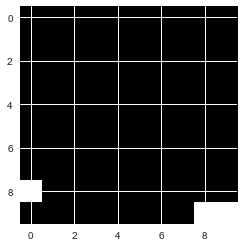

In [14]:
# Define environment/game
env = Catch(grid_size)

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

# Train Keras model to play Catch
train(model=model,
      n_epochs=50)

Action End Test, Points: -6


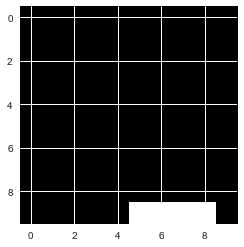

In [15]:
# Train Keras model to play Catch
test(model)

__TODO__: Train model to get max points in test. You can tune current model or define another architecture.